In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.utils import plot_model
import numpy as np

# Hyperparameters initialization

In [ ]:
BATCH_SIZE = 512
EPOCHS = 20
LEARNING_RATE = 0.001

# Preparing train and test datasets

In [ ]:
#(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
(train_data, val_data, test_data), metadata = tfds.load('mnist',
                                                        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                        with_info=True)
print(metadata.features)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


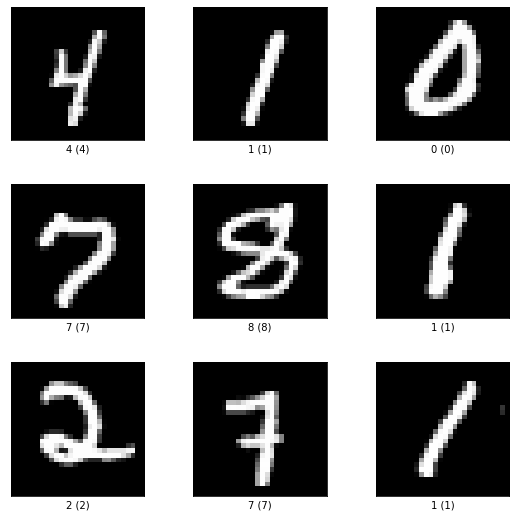

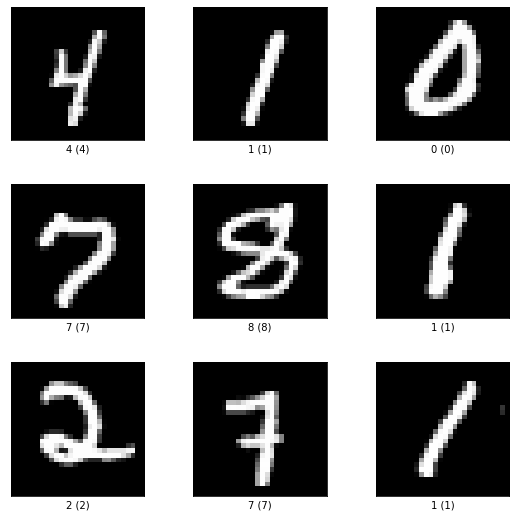

In [ ]:
tfds.visualization.show_examples(train_data, metadata)

In [ ]:
def preprocess(dataset):
    image = tf.cast(dataset['image'], dtype=tf.float32) / 255.
    label = tf.cast(dataset['label'], dtype=tf.float32)
    return image, label


train_data = train_data.map(preprocess).shuffle(buffer_size=1024).batch(BATCH_SIZE)
val_data = val_data.map(preprocess).batch(BATCH_SIZE)
test_data = test_data.map(preprocess).batch(BATCH_SIZE)

# Defining Classification Model

In [ ]:
def simple_convolution_model(num_classes):
    input_ = tf.keras.layers.Input(shape=(28, 28, 1,))
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    #x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_ = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.models.Model(input_, output_, name='Classifier')

def simple_mlp_model(num_classes):
    input_ = tf.keras.layers.Input(shape=(28, 28, 1,))
    x = tf.keras.layers.Flatten()(input_)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    output_ = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.models.Model(input_, output_, name='Classifier')

num_classes = metadata.features['label'].num_classes
model = simple_mlp_model(num_classes)
model.summary()

Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 7, 32)          0

# Training model

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(LEARNING_RATE,
                                                             decay_steps=100000,
                                                             decay_rate=0.96)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data)

Epoch 1/200
94/94 [==============================] - 4s 36ms/step - loss: 0.0445 - accuracy: 0.9862 - val_loss: 0.0349 - val_accuracy: 0.9883
Epoch 2/200
94/94 [==============================] - 3s 35ms/step - loss: 0.0444 - accuracy: 0.9856 - val_loss: 0.0339 - val_accuracy: 0.9897
Epoch 3/200
94/94 [==============================] - 3s 36ms/step - loss: 0.0399 - accuracy: 0.9871 - val_loss: 0.0291 - val_accuracy: 0.9908
Epoch 4/200
94/94 [==============================] - 3s 35ms/step - loss: 0.0403 - accuracy: 0.9870 - val_loss: 0.0316 - val_accuracy: 0.9900
Epoch 5/200
94/94 [==============================] - 3s 36ms/step - loss: 0.0389 - accuracy: 0.9869 - val_loss: 0.0288 - val_accuracy: 0.9902
Epoch 6/200
94/94 [==============================] - 3s 34ms/step - loss: 0.0365 - accuracy: 0.9881 - val_loss: 0.0302 - val_accuracy: 0.9910
Epoch 7/200
94/94 [==============================] - 3s 33ms/step - loss: 0.0368 - accuracy: 0.9886 - val_loss: 0.0431 - val_accuracy: 0.9847
Epoch 

KeyboardInterrupt: ignored

# Evaluation Model results

In [ ]:
metrics = model.evaluate(test_data, batch_size=BATCH_SIZE, verbose=1)
metric_names = ['Test loss', 'Test Accuracy']

for name, value in zip(metric_names, metrics):
    print(f'{name} : {value}')

12/12 [==============================] - 0s 15ms/step - loss: 0.0528 - accuracy: 0.9850
Test loss : 0.05280325189232826
Test Accuracy : 0.9850000143051147


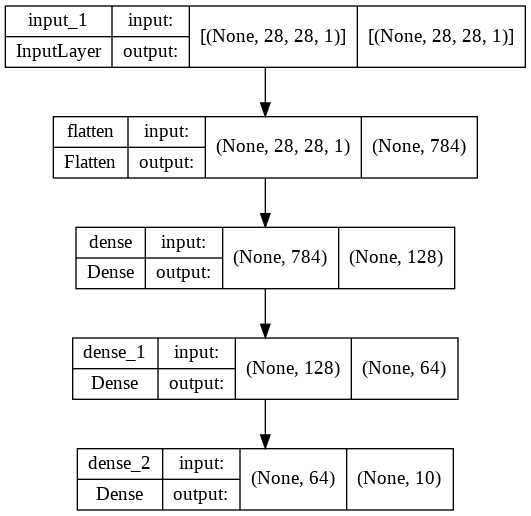

In [ ]:
plot_model(model, show_shapes=True, expand_nested=True)

# Confusion matrix

In [ ]:
prediction = model.predict(test_data)
prediction = np.argmax(prediction, axis=1)

ground_truth = np.concatenate([y for x, y in test_data], axis=0)
matrix = tf.math.confusion_matrix(prediction, ground_truth)

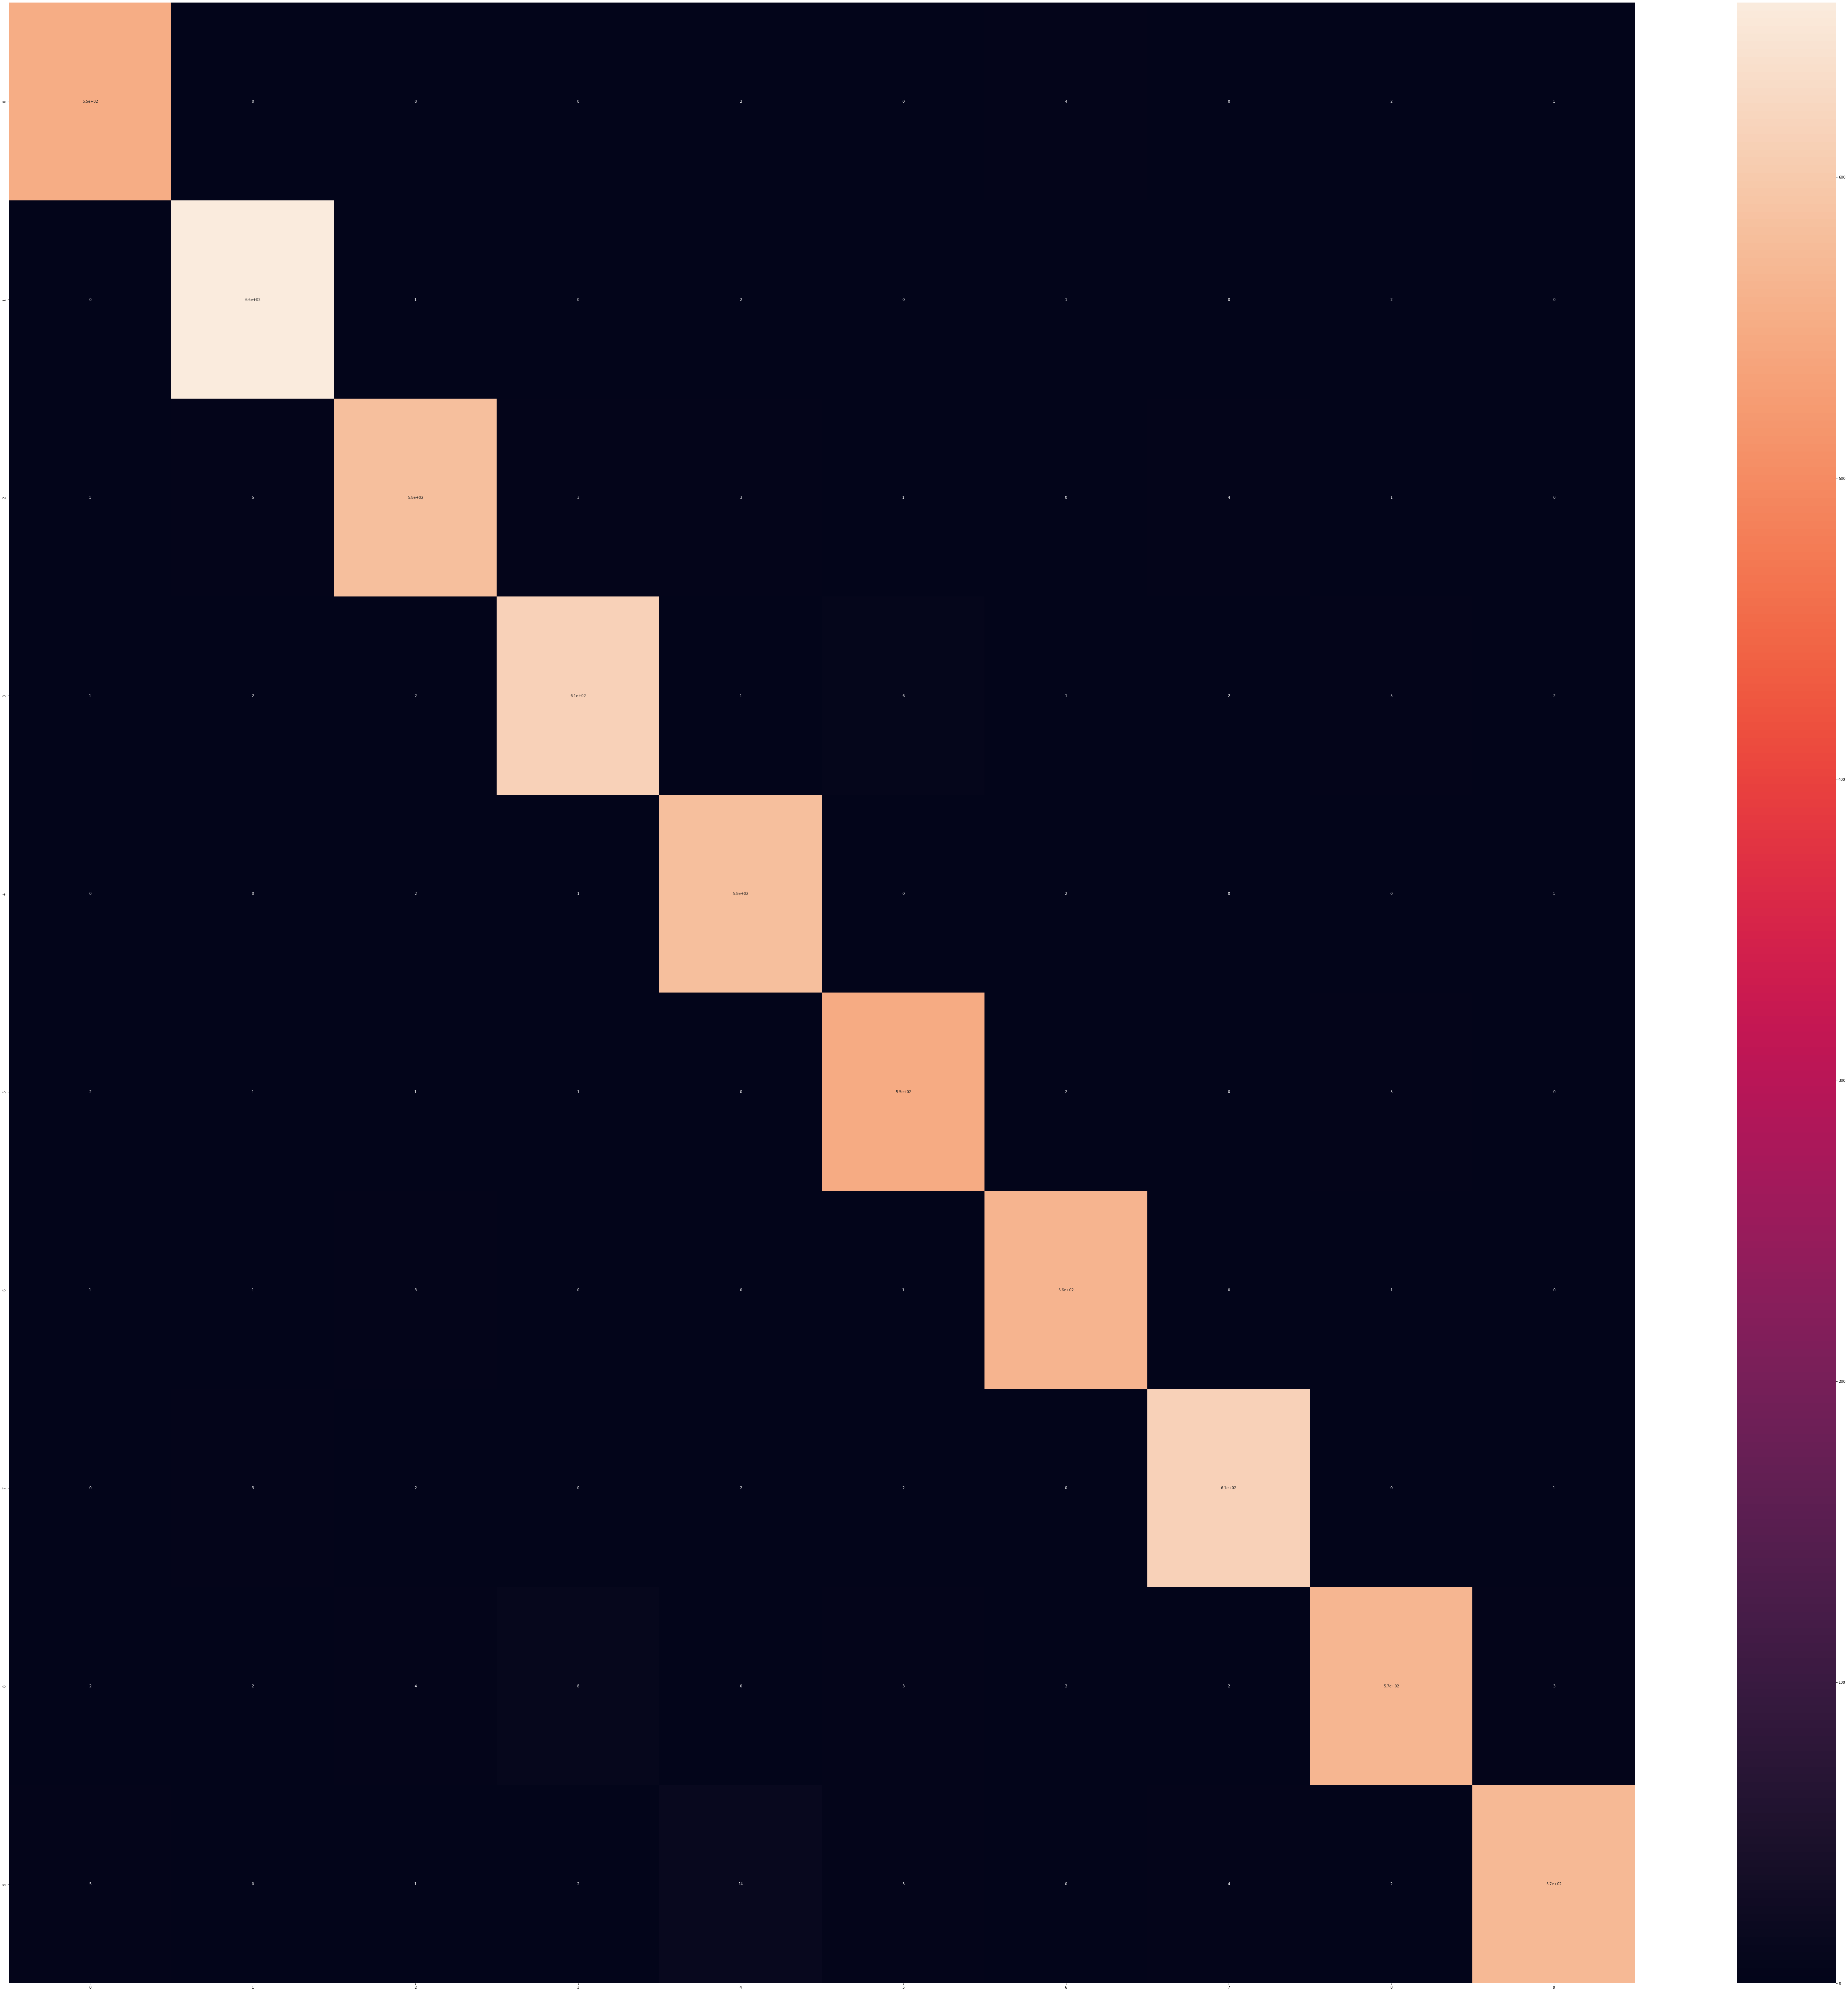

In [ ]:
df_cm = pd.DataFrame(matrix.numpy(), range(num_classes), range(num_classes))
plt.figure(figsize = (100,100))
svm = sn.heatmap(df_cm, annot=True)
plt.show()

# Plotting train, test losses and accuracy

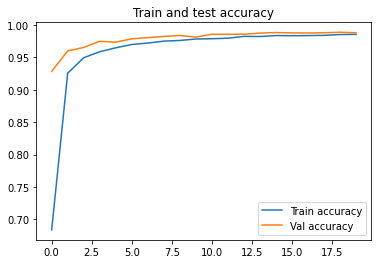

<Figure size 7200x7200 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val accuracy')
plt.title('Train and test accuracy')
plt.legend()
plt.figure(figsize = (100,100))
plt.show()

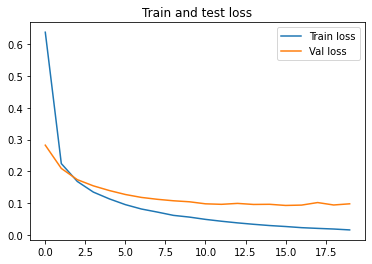

<Figure size 14400x14400 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.title('Train and test loss')
plt.legend()
plt.figure(figsize = (200,200))
plt.show()